# Aging Aware with Model Variation
Previously, we optimize the following functional:
$$ \min_\theta \, \int_{t=0}^{1} \; L(\theta(t)) \, {\rm d}t. $$
The optimum is for a specific aging model $\omega$, i.e., we minimized the 
$$ \min_\theta \, \int_{t=0}^{1} \; L(\theta(t,\omega)) \, {\rm d}t. $$
However, we dont know how will the resistance decay, i.e., we should also minimize the loss function w.r.t. aging models with different parameters. That means we need to optimized
$$ \min_\theta \, \int_{\omega}\int_{t=0}^{1} \; L(\theta(t,\omega)) \, {\rm d}t\, p(\omega){\rm d}\omega. $$
The Mento Carlo Approximation is then
$$
\min_{\theta_{\rm init}} \frac{1}{\Omega}\frac{1}{K}\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right),
$$
where $\mathfrak{M}$ is the set of $\Omega$ elements following the distribution $p(\omega)$. $p(\omega)$ is the distributions of parameters of the aging model. We have already obtained these distributions as we modeled the aging decay.

That means we should optimize this problem by
$$
\begin{align}
\theta_{\rm init}&:=\theta_{\rm init} - \alpha\cdot\nabla_{\theta_{\rm init}}\left(\frac{1}{\Omega}\frac{1}{K}\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{\Omega K}\cdot\nabla_{\theta_{\rm init}}\left(\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{\Omega K}\left(\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} }\nabla_{\theta_{\rm init}} L \left(\theta[k, \omega]\right)\right)
\end{align}
$$

# Import library

In [1]:
import importlib
from torch.autograd import Variable
import torch
import pickle
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pNN_aging_aware_vectorization as pnnv
import training_vectorization as tv
import random
sys.path.append(os.path.join(os.getcwd(), 'Aging_Model'))

# Random Seed

In [2]:
seed = 1

random.seed(seed);
np.random.seed(seed);
torch.manual_seed(seed);

# Get Aging Model

In [3]:
with open(os.path.join(os.getcwd(), 'Aging_Model', 'exp_aging_model.p'), 'rb') as f:
    age_generator = pickle.load(f)

# Device

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cuda:0')
device

device(type='cuda', index=0)

# Prepare data

## Dataset

In [5]:
ds = 'BankNote'

## Load data

In [6]:
datapath = os.path.join(os.getcwd(), 'Datasets', 'Haibin',
                        'data_processed', f'Dataset_{ds}.p')
with open(datapath, 'rb') as f:
    dataset = pickle.load(f)
X = dataset['X'].float()
y = dataset['y']

E, N_features, N_class = X.shape[0], X.shape[1], torch.max(
    torch.unique(y)).item()+1
X.shape, y.shape, E, N_features, N_class

(torch.Size([1372, 4]), torch.Size([1372]), 1372, 4, 2)

## Pseudo-electrical Signal

In [7]:
X = X / (torch.max(X, axis=0)[0] - torch.min(X, axis=0)[0])
X = X - torch.min(X, axis=0)[0]
torch.min(X), torch.max(X)

(tensor(0.), tensor(1.))

In [8]:
X[:10, :9]

tensor([[0.7690, 0.8396, 0.1068, 0.7366],
        [0.8357, 0.8210, 0.1218, 0.6443],
        [0.7866, 0.4166, 0.3106, 0.7870],
        [0.7571, 0.8717, 0.0549, 0.4504],
        [0.5316, 0.3487, 0.4247, 0.6874],
        [0.8229, 0.8773, 0.0571, 0.4897],
        [0.7668, 0.6281, 0.2591, 0.8286],
        [0.6587, 0.2605, 0.5923, 0.7225],
        [0.7388, 0.7309, 0.1953, 0.7216],
        [0.6186, 0.8588, 0.1299, 0.7104]])

In [9]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

# generate tensordataset
dataset = TensorDataset(X.to(device), y.to(device))

# split
train_rate = 0.6
test_rate = 0.2
valid_rate = 0.2
E_train = min(4096, int(E*train_rate))
E_test = min(1024, int(E*test_rate))
E_valid = min(1024, int(E*valid_rate))

train_data, rest_data = random_split(dataset, [E_train, E-E_train])
test_data, rest_data = random_split(rest_data, [E_test, E-E_train-E_test])
valid_data, rest_data = random_split(rest_data, [E_valid, E-E_train-E_test-E_valid])

len(train_data), len(test_data), len(valid_data)

(823, 274, 274)

In [10]:
# batch
train_loader = DataLoader(train_data, batch_size=len(train_data))
test_loader = DataLoader(test_data, batch_size=len(test_data))
valid_loader = DataLoader(valid_data, batch_size=len(valid_data))

# Hyperparameter

In [11]:
N_Hidden = 1
m = 0.3
T = 0.1
M_train = 100
K_train = 20
M_test = 20
K_test = 10

# Normal NN

## Define

In [12]:
NN = torch.nn.Sequential(torch.nn.Linear(N_features, N_Hidden), torch.nn.Tanh(),
                        torch.nn.Linear(N_Hidden, N_class), torch.nn.Tanh())


def weights_init(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

NN.apply(weights_init)

celoss = torch.nn.CrossEntropyLoss()
NN.to(device)

Sequential(
  (0): Linear(in_features=4, out_features=1, bias=True)
  (1): Tanh()
  (2): Linear(in_features=1, out_features=2, bias=True)
  (3): Tanh()
)

## Training

In [13]:
optimizer_NN = torch.optim.Adam(NN.parameters(), lr=0.1)
train_loader = DataLoader(train_data, batch_size=min(len(train_data),1024))
train_loss_NN, test_loss_NN, parameter_NN = tv.train_normal_nn(NN,
                                                                     train_loader,
                                                                     test_loader,
                                                                     optimizer=optimizer_NN,
                                                                     lossfunction=celoss,
                                                                     Epoch=50000)

  0%|          | 0/50000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.57299 | Loss: 0.675966263
| Epoch:   500 | Accuracy: 0.99270 | Loss: 0.143459633
| Epoch:  1000 | Accuracy: 0.99270 | Loss: 0.142935753
| Epoch:  1500 | Accuracy: 0.99270 | Loss: 0.142160743
| Epoch:  2000 | Accuracy: 0.99270 | Loss: 0.141845226
| Epoch:  2500 | Accuracy: 0.99270 | Loss: 0.141706526
| Epoch:  3000 | Accuracy: 0.99270 | Loss: 0.141636580
| Epoch:  3500 | Accuracy: 0.99270 | Loss: 0.141597494
| Epoch:  4000 | Accuracy: 0.99270 | Loss: 0.141574055
| Epoch:  4500 | Accuracy: 0.99270 | Loss: 0.141559228
| Epoch:  5000 | Accuracy: 0.99270 | Loss: 0.141549483
| Epoch:  5500 | Accuracy: 0.99270 | Loss: 0.141542882
| Epoch:  6000 | Accuracy: 0.99270 | Loss: 0.141538322
| Epoch:  6500 | Accuracy: 0.99270 | Loss: 0.141535118
| Epoch:  7000 | Accuracy: 0.99270 | Loss: 0.141532823
| Epoch:  7500 | Accuracy: 0.99270 | Loss: 0.141531169
| Epoch:  8000 | Accuracy: 0.99270 | Loss: 0.141529977
| Epoch:  8500 | Accuracy: 0.99270 | Loss: 0.141529098
| Epoch:  

(18815, 0.14152656495571136)

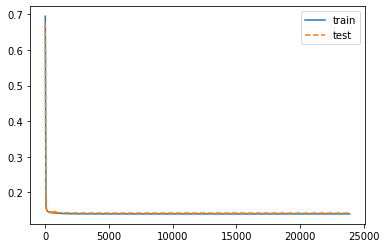

In [14]:
plt.plot(train_loss_NN, '-', label='train')
plt.plot(test_loss_NN, '--', label='test')
plt.legend()
NN.load_state_dict(parameter_NN)
best = np.argmin(test_loss_NN)
best, test_loss_NN[best]

In [15]:
optimizer_NN = torch.optim.Adam(NN.parameters(), lr=0.01)
train_loader = DataLoader(train_data, batch_size=len(train_data))
train_loss_NN, test_loss_NN, parameter_NN = tv.train_normal_nn(NN,
                                                                     train_loader,
                                                                     test_loader,
                                                                     optimizer=optimizer_NN,
                                                                     lossfunction=celoss,
                                                                     Epoch=50000)

  0%|          | 0/50000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.99270 | Loss: 0.141526580
| Epoch:   500 | Accuracy: 0.99270 | Loss: 0.141526565
| Epoch:  1000 | Accuracy: 0.99270 | Loss: 0.141526565
| Epoch:  1500 | Accuracy: 0.99270 | Loss: 0.141526565
| Epoch:  2000 | Accuracy: 0.99270 | Loss: 0.141526565
| Epoch:  2500 | Accuracy: 0.99270 | Loss: 0.141526565
| Epoch:  3000 | Accuracy: 0.99270 | Loss: 0.141526565
| Epoch:  3500 | Accuracy: 0.99270 | Loss: 0.141526565
| Epoch:  4000 | Accuracy: 0.99270 | Loss: 0.141526565
| Epoch:  4500 | Accuracy: 0.99270 | Loss: 0.141526565
| Epoch:  5000 | Accuracy: 0.99270 | Loss: 0.141526565
Early stop.
Finished.


(1, 0.14152656495571136)

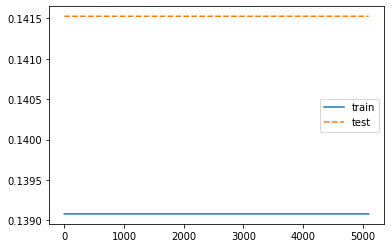

In [16]:
plt.plot(train_loss_NN, '-', label='train')
plt.plot(test_loss_NN, '--', label='test')
plt.legend()
NN.load_state_dict(parameter_NN)
best = np.argmin(test_loss_NN)
best, test_loss_NN[best]

In [17]:
optimizer_NN = torch.optim.Adam(NN.parameters(), lr=0.001)
train_loader = DataLoader(train_data, batch_size=len(train_data))
train_loss_NN, test_loss_NN, parameter_NN = tv.train_normal_nn(NN,
                                                                     train_loader,
                                                                     test_loader,
                                                                     optimizer=optimizer_NN,
                                                                     lossfunction=celoss,
                                                                     Epoch=50000)

  0%|          | 0/50000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.99270 | Loss: 0.141526565
| Epoch:   500 | Accuracy: 0.99270 | Loss: 0.141526565
| Epoch:  1000 | Accuracy: 0.99270 | Loss: 0.141526565
| Epoch:  1500 | Accuracy: 0.99270 | Loss: 0.141526565
| Epoch:  2000 | Accuracy: 0.99270 | Loss: 0.141526565
| Epoch:  2500 | Accuracy: 0.99270 | Loss: 0.141526565
| Epoch:  3000 | Accuracy: 0.99270 | Loss: 0.141526565
| Epoch:  3500 | Accuracy: 0.99270 | Loss: 0.141526565
| Epoch:  4000 | Accuracy: 0.99270 | Loss: 0.141526565
| Epoch:  4500 | Accuracy: 0.99270 | Loss: 0.141526565
| Epoch:  5000 | Accuracy: 0.99270 | Loss: 0.141526565
Early stop.
Finished.


(0, 0.14152656495571136)

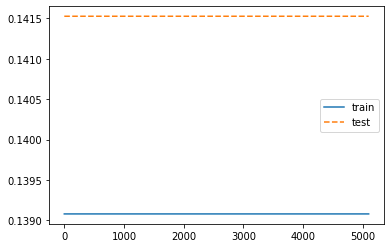

In [18]:
plt.plot(train_loss_NN, '-', label='train')
plt.plot(test_loss_NN, '--', label='test')
plt.legend()
NN.load_state_dict(parameter_NN)
best = np.argmin(test_loss_NN)
best, test_loss_NN[best]

## Save Model

In [19]:
with open(f'./result/{ds}_NN_{seed}.p', 'wb') as f:
    pickle.dump(NN, f)

## Evaluation

In [20]:
for x_valid, y_valid in valid_loader:
    prediction_valid = NN(x_valid)
    p = torch.argmax(prediction_valid, 1)
    pred_y = p.cpu().data.numpy().squeeze()
    acc_valid = sum(pred_y == y_valid.cpu().numpy()) / y_valid.shape[0]
print(acc_valid)

0.9890510948905109


In [21]:
NN.to('cpu')

Sequential(
  (0): Linear(in_features=4, out_features=1, bias=True)
  (1): Tanh()
  (2): Linear(in_features=1, out_features=2, bias=True)
  (3): Tanh()
)

# Normal PNN

## Define

In [22]:
PNN = torch.nn.Sequential(pnnv.PNNLayer(N_features, N_Hidden, age_generator, xpu=device),
                         pnnv.PNNLayer(N_Hidden, N_class, age_generator, xpu=device))

PNN.apply(lambda z: pnnv.MakeModel(z, M=1))
PNN.apply(lambda z: pnnv.SetTime(z, t=[0]))

PNN.to(device)

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
)

## Training

In [23]:
optimizer_PNN = torch.optim.Adam(PNN.parameters(), lr=0.1)
train_loader = DataLoader(train_data, batch_size=min(len(train_data),1024))
train_loss_PNN, test_loss_PNN, parameter_PNN = tv.train_normal_pnn(PNN, train_loader, test_loader,
                                                                   m, T, optimizer_PNN,
                                                                   pnnv.LossFunction, Epoch=50000, cache=ds)

  0%|          | 0/50000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.57299 | Loss: 0.662774682 |
| Epoch:   500 | Accuracy: 0.99270 | Loss: 0.017311504 |
| Epoch:  1000 | Accuracy: 0.99270 | Loss: 0.013461598 |
| Epoch:  1500 | Accuracy: 0.99270 | Loss: 0.014049752 |
| Epoch:  2000 | Accuracy: 0.99270 | Loss: 0.014369144 |
| Epoch:  2500 | Accuracy: 0.99270 | Loss: 0.015473736 |
| Epoch:  3000 | Accuracy: 0.99270 | Loss: 0.015560038 |
| Epoch:  3500 | Accuracy: 0.99270 | Loss: 0.014651523 |
| Epoch:  4000 | Accuracy: 0.99270 | Loss: 0.015141966 |
| Epoch:  4500 | Accuracy: 0.99270 | Loss: 0.014313514 |
| Epoch:  5000 | Accuracy: 0.99270 | Loss: 0.014636669 |
| Epoch:  5500 | Accuracy: 0.99270 | Loss: 0.014404395 |
Early stop.
Finished.


(1160, 0.01286575198173523)

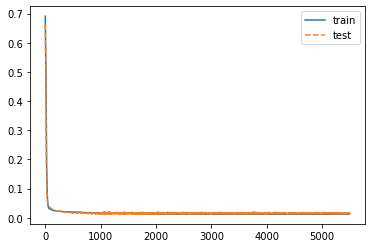

In [24]:
plt.plot(train_loss_PNN, '-', label='train')
plt.plot(test_loss_PNN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_PNN)
PNN.load_state_dict(parameter_PNN)
best, test_loss_PNN[best]

In [25]:
optimizer_PNN = torch.optim.Adam(PNN.parameters(), lr=0.01)
train_loader = DataLoader(train_data, batch_size=len(train_data))
train_loss_PNN, test_loss_PNN, parameter_PNN = tv.train_normal_pnn(PNN, train_loader, test_loader,
                                                                   m, T, optimizer_PNN,
                                                                   pnnv.LossFunction, Epoch=50000, cache=ds)

  0%|          | 0/50000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.99270 | Loss: 0.013474650 |
| Epoch:   500 | Accuracy: 0.99270 | Loss: 0.014247088 |
| Epoch:  1000 | Accuracy: 0.99270 | Loss: 0.014998481 |
| Epoch:  1500 | Accuracy: 0.99270 | Loss: 0.014770414 |
| Epoch:  2000 | Accuracy: 0.99270 | Loss: 0.014799266 |
| Epoch:  2500 | Accuracy: 0.99270 | Loss: 0.014582678 |
| Epoch:  3000 | Accuracy: 0.99270 | Loss: 0.014580307 |
| Epoch:  3500 | Accuracy: 0.99270 | Loss: 0.014405381 |
| Epoch:  4000 | Accuracy: 0.99270 | Loss: 0.014602927 |
| Epoch:  4500 | Accuracy: 0.99270 | Loss: 0.014577527 |
| Epoch:  5000 | Accuracy: 0.99270 | Loss: 0.014740648 |
Early stop.
Finished.


(0, 0.013474649749696255)

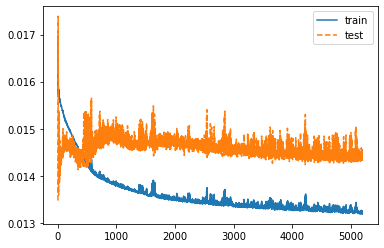

In [26]:
plt.plot(train_loss_PNN, '-', label='train')
plt.plot(test_loss_PNN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_PNN)
PNN.load_state_dict(parameter_PNN)
best, test_loss_PNN[best]

In [27]:
optimizer_PNN = torch.optim.Adam(PNN.parameters(), lr=0.001)
train_loader = DataLoader(train_data, batch_size=len(train_data))
train_loss_PNN, test_loss_PNN, parameter_PNN = tv.train_normal_pnn(PNN, train_loader, test_loader,
                                                                   m, T, optimizer_PNN,
                                                                   pnnv.LossFunction, Epoch=50000, cache=ds)

  0%|          | 0/50000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.99270 | Loss: 0.013570947 |
| Epoch:   500 | Accuracy: 0.99270 | Loss: 0.014545009 |
| Epoch:  1000 | Accuracy: 0.99270 | Loss: 0.014664756 |
| Epoch:  1500 | Accuracy: 0.99270 | Loss: 0.014579586 |
| Epoch:  2000 | Accuracy: 0.99270 | Loss: 0.014568313 |
| Epoch:  2500 | Accuracy: 0.99270 | Loss: 0.014453134 |
| Epoch:  3000 | Accuracy: 0.99270 | Loss: 0.014394825 |
| Epoch:  3500 | Accuracy: 0.99270 | Loss: 0.014404115 |
| Epoch:  4000 | Accuracy: 0.99270 | Loss: 0.014494821 |
| Epoch:  4500 | Accuracy: 0.99270 | Loss: 0.014456100 |
| Epoch:  5000 | Accuracy: 0.99270 | Loss: 0.014503816 |
Early stop.
Finished.


(0, 0.013570946641266346)

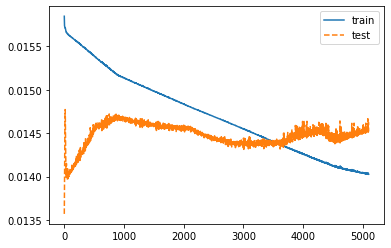

In [28]:
plt.plot(train_loss_PNN, '-', label='train')
plt.plot(test_loss_PNN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_PNN)
PNN.load_state_dict(parameter_PNN)
best, test_loss_PNN[best]

## Save Model

In [29]:
with open(f'./result/{ds}_PNN_{seed}.p', 'wb') as f:
    pickle.dump(PNN, f)

In [30]:
PNN.to('cpu')

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
)

# Aging Aware PNN

In [31]:
AAPNN = torch.nn.Sequential(pnnv.PNNLayer(N_features, N_Hidden, age_generator, xpu=device),
                           pnnv.PNNLayer(N_Hidden, N_class, age_generator, xpu=device))

AAPNN.apply(lambda z: pnnv.MakeModel(z, M_train))
AAPNN.apply(lambda z: pnnv.SetTime(z, np.random.rand(K_train).tolist()))

AAPNN.to(device)

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
)

## Reload AAPNN if crash

In [32]:
# if os.path.exists(f'./temp/{ds}_AAPNN.p'): 
#     with open(f'./temp/{ds}_AAPNN.p', 'rb') as f:
#         AAPNN = pickle.load(f)

## Training

In [33]:
optimizer_AAPNN = torch.optim.Adam(AAPNN.parameters(), lr=0.1)
train_loader = DataLoader(train_data, batch_size=min(len(train_data),1024))
train_loss_AAPNN, test_loss_AAPNN, parameter_AAPNN = tv.train_aged_pnn(AAPNN, train_loader, test_loader,
                                        m, T, M_train, K_train, M_test, K_test,
                                        optimizer_AAPNN, pnnv.LossFunction,
                                        Epoch=1000, cache=ds)

  0%|          | 0/1000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.51505 | Loss: 0.727129400 |
| Epoch:    50 | Accuracy: 0.73349 | Loss: 0.492815197 |
| Epoch:   100 | Accuracy: 0.85075 | Loss: 0.290644795 |
| Epoch:   150 | Accuracy: 0.87502 | Loss: 0.247114822 |
| Epoch:   200 | Accuracy: 0.91520 | Loss: 0.166716784 |
| Epoch:   250 | Accuracy: 0.93832 | Loss: 0.112989604 |
| Epoch:   300 | Accuracy: 0.95883 | Loss: 0.086865216 |
| Epoch:   350 | Accuracy: 0.94752 | Loss: 0.107927315 |
| Epoch:   400 | Accuracy: 0.95334 | Loss: 0.099771932 |
| Epoch:   450 | Accuracy: 0.95212 | Loss: 0.093435891 |
| Epoch:   500 | Accuracy: 0.95841 | Loss: 0.080269903 |
| Epoch:   550 | Accuracy: 0.96637 | Loss: 0.065057762 |
| Epoch:   600 | Accuracy: 0.96276 | Loss: 0.075586200 |
| Epoch:   650 | Accuracy: 0.96057 | Loss: 0.078157574 |
| Epoch:   700 | Accuracy: 0.97078 | Loss: 0.054802492 |
| Epoch:   750 | Accuracy: 0.96996 | Loss: 0.056433246 |
| Epoch:   800 | Accuracy: 0.96613 | Loss: 0.063108668 |
| Epoch:   850 | Accuracy: 0.96

(840, 0.04004484415054321)

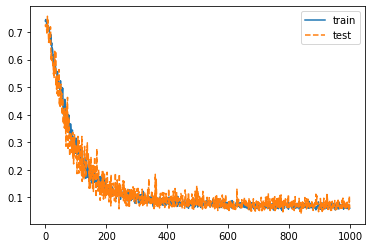

In [34]:
plt.plot(train_loss_AAPNN, '-', label='train')
plt.plot(test_loss_AAPNN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_AAPNN)
AAPNN.load_state_dict(parameter_AAPNN)
best, test_loss_AAPNN[best]

In [35]:
optimizer_AAPNN = torch.optim.Adam(AAPNN.parameters(), lr=0.01)
train_loader = DataLoader(train_data, batch_size=len(train_data))
train_loss_AAPNN, test_loss_AAPNN, parameter_AAPNN = tv.train_aged_pnn(AAPNN, train_loader, test_loader,
                                        m, T, M_train, K_train, M_test, K_test,
                                        optimizer_AAPNN, pnnv.LossFunction,
                                        Epoch=1000, cache=ds)

  0%|          | 0/1000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.96104 | Loss: 0.077095345 |
| Epoch:    50 | Accuracy: 0.94130 | Loss: 0.118274875 |
| Epoch:   100 | Accuracy: 0.96965 | Loss: 0.059080448 |
| Epoch:   150 | Accuracy: 0.95245 | Loss: 0.091966137 |
| Epoch:   200 | Accuracy: 0.96984 | Loss: 0.063339546 |
| Epoch:   250 | Accuracy: 0.96936 | Loss: 0.056280140 |
| Epoch:   300 | Accuracy: 0.96661 | Loss: 0.070231631 |
| Epoch:   350 | Accuracy: 0.96843 | Loss: 0.058717370 |
| Epoch:   400 | Accuracy: 0.96723 | Loss: 0.077028930 |
| Epoch:   450 | Accuracy: 0.95653 | Loss: 0.091878839 |
| Epoch:   500 | Accuracy: 0.96007 | Loss: 0.076510027 |
| Epoch:   550 | Accuracy: 0.97142 | Loss: 0.056897987 |
| Epoch:   600 | Accuracy: 0.97192 | Loss: 0.054590046 |
| Epoch:   650 | Accuracy: 0.96387 | Loss: 0.082081646 |
| Epoch:   700 | Accuracy: 0.96082 | Loss: 0.078971021 |
| Epoch:   750 | Accuracy: 0.96916 | Loss: 0.062053952 |
| Epoch:   800 | Accuracy: 0.96144 | Loss: 0.073359996 |
| Epoch:   850 | Accuracy: 0.96

(752, 0.04375462234020233)

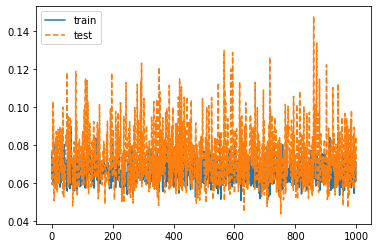

In [36]:
plt.plot(train_loss_AAPNN, '-', label='train')
plt.plot(test_loss_AAPNN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_AAPNN)
AAPNN.load_state_dict(parameter_AAPNN)
best, test_loss_AAPNN[best]

In [37]:
optimizer_AAPNN = torch.optim.Adam(AAPNN.parameters(), lr=0.001)
train_loader = DataLoader(train_data, batch_size=len(train_data))
train_loss_AAPNN, test_loss_AAPNN, parameter_AAPNN = tv.train_aged_pnn(AAPNN, train_loader, test_loader,
                                        m, T, M_train, K_train, M_test, K_test,
                                        optimizer_AAPNN, pnnv.LossFunction,
                                        Epoch=1000, cache=ds)

  0%|          | 0/1000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.96934 | Loss: 0.061208807 |
| Epoch:    50 | Accuracy: 0.96095 | Loss: 0.078237318 |
| Epoch:   100 | Accuracy: 0.96980 | Loss: 0.060274307 |
| Epoch:   150 | Accuracy: 0.96456 | Loss: 0.072311491 |
| Epoch:   200 | Accuracy: 0.95396 | Loss: 0.090686515 |
| Epoch:   250 | Accuracy: 0.96188 | Loss: 0.074275322 |
| Epoch:   300 | Accuracy: 0.96254 | Loss: 0.073256671 |
| Epoch:   350 | Accuracy: 0.95706 | Loss: 0.083547696 |
| Epoch:   400 | Accuracy: 0.95177 | Loss: 0.092771210 |
| Epoch:   450 | Accuracy: 0.95580 | Loss: 0.088034987 |
| Epoch:   500 | Accuracy: 0.95839 | Loss: 0.080098048 |
| Epoch:   550 | Accuracy: 0.95739 | Loss: 0.082393378 |
| Epoch:   600 | Accuracy: 0.97279 | Loss: 0.051638305 |
| Epoch:   650 | Accuracy: 0.96909 | Loss: 0.057942115 |
| Epoch:   700 | Accuracy: 0.96440 | Loss: 0.069792069 |
| Epoch:   750 | Accuracy: 0.96982 | Loss: 0.065591715 |
| Epoch:   800 | Accuracy: 0.97013 | Loss: 0.063335054 |
| Epoch:   850 | Accuracy: 0.94

(348, 0.044266846030950546)

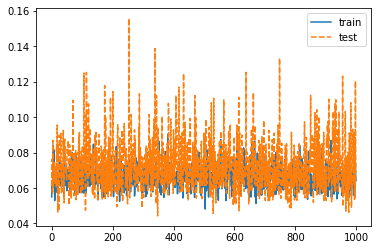

In [38]:
plt.plot(train_loss_AAPNN, '-', label='train')
plt.plot(test_loss_AAPNN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_AAPNN)
AAPNN.load_state_dict(parameter_AAPNN)
best, test_loss_AAPNN[best]

## Save Model

In [39]:
with open(f'./result/{ds}_AAPNN_{seed}.p', 'wb') as f:
    pickle.dump(AAPNN, f)